In [475]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
from scipy.signal import find_peaks
import os
# import importlib
# import seaborn as sns

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

### Load Data

In [476]:
folder_path = user_path + '/PHYS469/saturation_spectroscopy/raw_data/10-31-2024/'
raw_probe_pump_data = {}
raw_probe_data = {}

for file_name in os.listdir(folder_path):
    file_name = file_name.strip()
    # Read the lines of the file
    with open(folder_path+file_name, 'r') as f:
        lines = f.readlines()
    # Find end of the header (the line that starts with 'x ys')
    for i, line in enumerate(lines):
        if line.startswith('x	y'):
            lines_to_skip = i
            break

    # Read data (skip header)
    data = np.genfromtxt(folder_path+file_name, skip_header=lines_to_skip, names=True, missing_values='_', filling_values=0)
    reshaped_data = np.vstack([data[field] for field in data.dtype.names]).T

    # Make a dict for the run
    file_dict = {label: reshaped_data[:,i] for i,label in enumerate(data.dtype.names)}
    # Add dict to data dict
    if 'run' in file_name:
        raw_probe_pump_data[file_name[:-4]] = file_dict
    else:
        raw_probe_data[file_name[:-4]] = file_dict

### Raw Data

In [477]:
raw_probe_pump_data.keys(), raw_probe_data.keys(), raw_probe_pump_data['run1'].keys()

(dict_keys(['run20', 'run9', 'run8', 'run19', 'run18', 'run6', 'run15', 'run14', 'run7', 'run5', 'run16', 'run17', 'run4', 'run13', 'run12', 'run1', 'run3', 'run10', 'run11', 'run2']),
 dict_keys(['nopump17', 'nopump16', 'nopump14', 'nopump15', 'nopump11', 'nopump10', 'nopump12', 'nopump13', 'nopump2', 'nopump3', 'nopump1', 'nopump4', 'nopump5', 'nopump7', 'nopump6', 'nopump8', 'nopump9', 'nopump20', 'nopump18', 'nopump19']),
 dict_keys(['x', 'y2', 'y3']))

Averaging the data for the runs

In [478]:
# make a single interferometer data array
# raw_inter1 = np.array([raw_probe_data[run]['y3'] for run in raw_probe_data.keys()])
# raw_inter2 = np.array([raw_probe_pump_data[run]['y3'] for run in raw_probe_pump_data.keys()])
# raw_inter = np.concatenate((raw_inter1, raw_inter2), axis=0)

In [479]:
# time = raw_probe_pump_data['run1']['x']
# avg_probe_pump = np.mean([raw_probe_pump_data[run]['y2'] for run in raw_probe_pump_data.keys()], axis=0)
# avg_probe = np.mean([raw_probe_data[run]['y2'] for run in raw_probe_data.keys() if run[:-1]=='nopump'], axis=0)
# avg_inter = np.mean([run for run in raw_inter], axis=0)

In [480]:
# # Figure
# fig, axes = plt.subplots(2, 1, figsize=(5,4), dpi=250)

# # Get a single frequency sweep
# start = np.argwhere(avg_inter == np.max(avg_inter))[0][0]
# stop = np.argwhere(avg_inter == np.min(avg_inter))[0][0]
# time_multiplier = 1e1
# time_axis = time[start:stop]*time_multiplier

# # Plot data
# axes[0].plot(time_axis, avg_probe_pump[start:stop], color='r', linewidth=0.1, label = 'Probe+Pump')
# axes[0].plot(time_axis, avg_probe[start:stop], color='b', linewidth=0.1, label='Probe')
# axes[0].plot(time_axis, avg_inter[start:stop], color='k', linewidth=0.1, label='Interferometer')
# axes[1].plot(time_axis, (avg_probe_pump-avg_probe)[start:stop], color='r', linewidth=0.1, label = 'Hyperfine Transitions')

# for ax in axes:
#     ax.set_xlabel('Time [s]')
#     ax.set_ylabel('Voltage [V]')
#     ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)
# plt.tight_layout()
# plt.show()


From our discussions, won't use the above data since averaging out everything smoothes too many of the features

Plotting raw data for a run

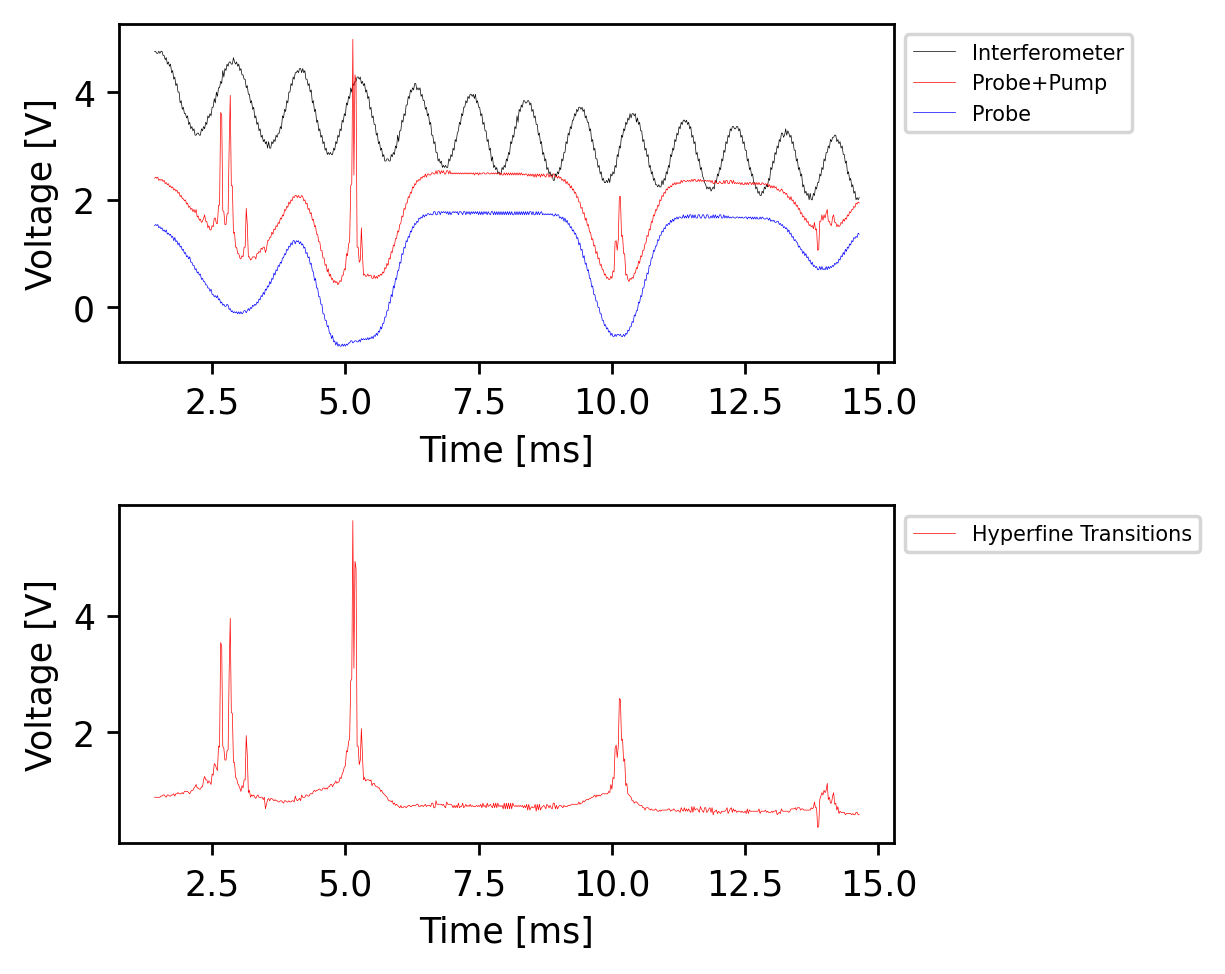

In [481]:
# Define the data for the chosen run
run_time = raw_probe_pump_data['run1']['x']
run_probe_pump = raw_probe_pump_data['run1']['y2']
run_inter = raw_probe_pump_data['run1']['y3']
probe = raw_probe_data['nopump1']['y2']  # Probe data, use the same for all probe+pump runs

# Get a single frequency sweep
start = np.argwhere(run_inter == np.max(run_inter))[0][0]
stop = np.argwhere(run_inter == np.min(run_inter))[0][0]
time_multiplier = 1e2  # ms
# Slice the data to the region of interest
sweep_time = run_time[start:stop]*time_multiplier
sweep_probe_pump = run_probe_pump[start:stop]
sweep_inter = run_inter[start:stop]
sweep_probe = probe[start:stop]

# Figure 1
fig, axes = plt.subplots(2, 1, figsize=(5,4), dpi=250)
# Plot data
axes[0].plot(sweep_time, sweep_inter, color='k', linewidth=0.2, label='Interferometer')
axes[0].plot(sweep_time, sweep_probe_pump, color='r', linewidth=0.2, label = 'Probe+Pump')
axes[0].plot(sweep_time, sweep_probe, color='b', linewidth=0.2, label='Probe')
axes[1].plot(sweep_time, sweep_probe_pump-sweep_probe, color='r', linewidth=0.2, label = 'Hyperfine Transitions')
# Labels
for ax in axes:
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Voltage [V]')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)
plt.tight_layout()
plt.show()

# Figure 2
# fig, ax = plt.subplots(2, 2, figsize=(5,4), dpi=250)
# Plot data



## Interferometer

In [482]:
# plot all interferometer runs on one plot
# plt.figure(figsize = (10, 6))
# for run in raw_inter:
#     plt.plot(run_time, run, color='k', linewidth=0.1)
# plt.xlabel('Time [s]')
# plt.ylabel('Voltage [V]')
# plt.show()


This isn't super matched up, so we'll get the frequency location for each run and then average at the end.

In [483]:
def find_local_maxima_inter(data):
    local_maxima = []
    for i in range(1, len(data) - 2):
        # check that its a local maxima
        if data[i] > data[i - 2] and data[i] > data[i + 2]:
            # check that another maxima wasn't found within 5 indices
            if len(local_maxima) == 0 or i - local_maxima[-1] > 5:
                local_maxima.append(i)
    return local_maxima

def find_local_maxima_hyper(data):
    local_maxima = []
    for i in range(1, len(data) - 2):
        # check that its a local maxima
        if data[i] > data[i - 2] and data[i] > data[i + 2]:
            # check that another maxima wasn't found within 5 indices
            local_maxima.append(i)
    return local_maxima

In [484]:
# FINDING THE HYPERFINE PEAK INDICES BY HAND FOR EACH RUN :(
hyperfine_peaks = {
    'run1':    [133, 142, 157,    257, 259, 265,    503, 507, 512,    697, 702, 708], 
    'run2':     [133, 142, 157,    257, 259, 265,    503, 507, 512,    697, 702, 708],
    'run3':     [133, 142, 157,    257, 259, 264,    503, 507, 512,    697, 702, 708],
    'run4':     [133, 142, 157,    256, 259, 264,    503, 507, 512,    697, 702, 708],
    'run5':     [133, 142, 156,    256, 259, 264,    503, 507, 512,    697, 702, 708],
    'run6':     [133, 142, 156,    256, 259, 264,    503, 507, 512,    697, 702, 708],
    'run7':     [132, 141, 156,    256, 258, 264,    503, 507, 512,    696, 702, 708],
    'run8':     [132, 141, 156,    256, 259, 264,    503, 507, 512,    696, 702, 708],
    'run9':     [132, 141, 156,    256, 258, 264,    503, 507, 512,    696, 702, 708],
    'run10':    [132, 140, 156,    256, 258, 264,    503, 507, 512,    696, 702, 708],
    'run11':    [126, 135, 150,    255, 258, 263,    503, 507, 512,    698, 703, 709],
    # 'run12': [],
    # 'run13': [],
    # 'run14': [],
    # 'run15': [],
    # 'run16': [],
    # 'run17': [],
    # 'run18': [],
    # 'run19': [],
    # 'run20': [],
}


Section for manually finding peaks below

** I think we should put a figure of this for one of the runs in the reporttt, maybe with thinner lines so we can see the peaks better? I dont think its worth it to put the raw data before we subtract off the no pump runs. oh also with the interferometer data + the fit + residuals. im putting this here so we dont forget and to see what you think, im not asking you to do it lmao (unless you want ofc). thsi could be our multipanel if we plot the run data on a diff panel than the interferometer

[2, 5, 7, 9, 14, 16, 19, 21, 26, 29, 34, 37, 39, 41, 43, 45, 47, 49, 52, 55, 57, 60, 62, 64, 72, 80, 84, 89, 93, 101, 106, 110, 115, 117, 119, 123, 125, 131, 134, 138, 140, 142, 145, 147, 149, 154, 157, 162, 164, 166, 174, 176, 178, 181, 184, 186, 198, 200, 202, 206, 214, 217, 221, 226, 232, 237, 239, 241, 243, 245, 255, 257, 263, 266, 269, 272, 274, 276, 280, 284, 294, 296, 299, 301, 307, 310, 313, 322, 324, 330, 335, 339, 342, 345, 347, 349, 352, 356, 358, 360, 363, 365, 367, 369, 371, 374, 376, 379, 383, 386, 389, 391, 393, 395, 397, 399, 401, 403, 405, 408, 410, 412, 414, 416, 418, 420, 422, 425, 428, 430, 432, 435, 437, 440, 442, 446, 448, 451, 453, 455, 457, 461, 466, 469, 471, 473, 475, 480, 484, 493, 495, 497, 499, 501, 503, 507, 510, 512, 514, 516, 520, 526, 532, 534, 537, 539, 541, 547, 549, 554, 556, 558, 560, 563, 565, 570, 572, 575, 577, 580, 584, 588, 594, 596, 598, 600, 603, 606, 608, 611, 620, 622, 624, 626, 628, 631, 633, 635, 638, 640, 642, 644, 647, 650, 654, 657, 66

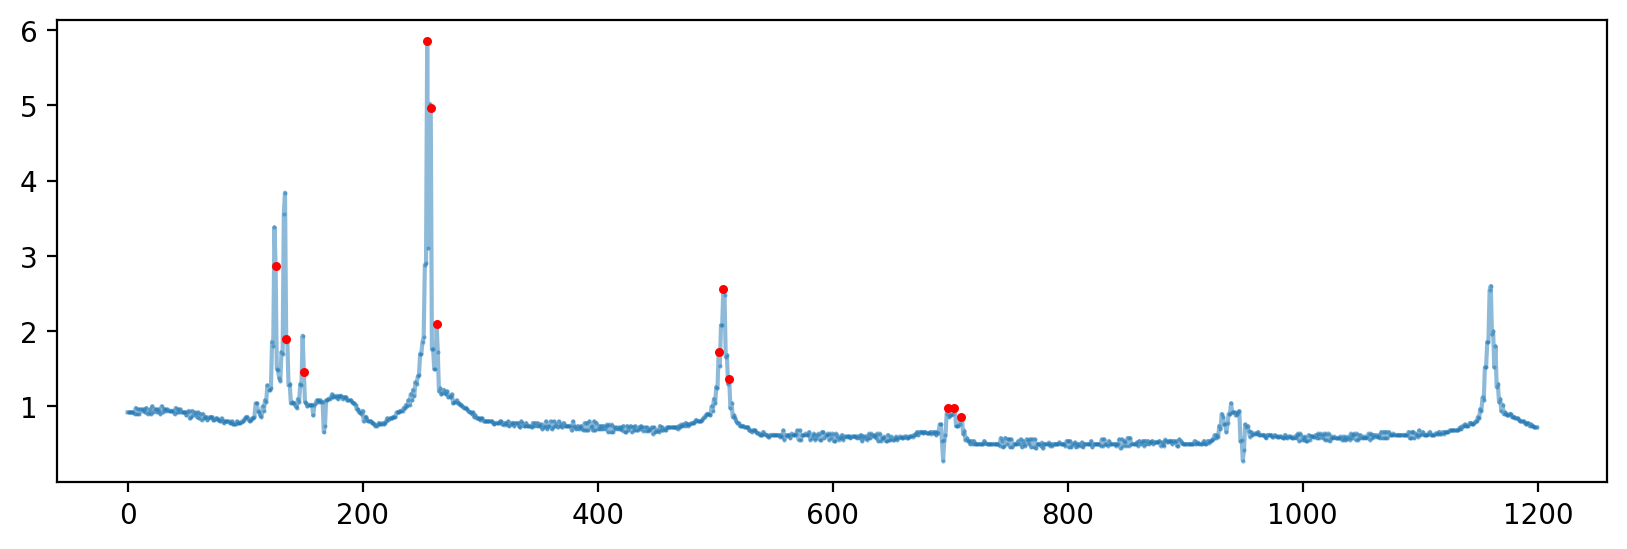

In [490]:
def find_local_maxima_hyper(data):
    local_maxima = []
    for i in range(1, len(data) - 1):
        # check that its a local maxima
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            # check that another maxima wasn't found within 5 indices
            local_maxima.append(i)
    return local_maxima

i = 12
# loading run
probe_data = raw_probe_pump_data['run'+str(i)]['y2'] - raw_probe_data['nopump1']['y2']
rough_peaks = find_local_maxima_hyper(probe_data)
print(rough_peaks)

plt.figure(figsize = (10, 3), dpi = 200)
plt.plot(np.arange(len(probe_data)), probe_data, zorder = 0, marker = '.', markersize = 1, alpha = 0.5)
# plot location of peaks
# plt.scatter(rough_peaks, probe_data[rough_peaks], color='r', s = 10)

# choosing indices of peaks
indices = [126, 135, 150,    255, 258, 263,    503, 507, 512,    698, 703, 709]

# plotting these points from the original data
plt.scatter(indices, probe_data[indices], color='r', s = 5)

# plt.xlim(50, 800)
# plt.xlim(100, 200)
# plt.xlim(200, 300)
# plt.xlim(475, 575)
# plt.xlim(600, 800)

$$ I(t) = A + A\cos\left(\frac{4\pi\Delta L}{c} f(t)\right) + g(t) $$
where f(t) is the frequency sweep, and g(t) is the ramp, with
$$ f(t) = f_o + \alpha t + \beta t^2 $$
and
$$ g(t) = a + bt $$

In [486]:
# defining fit function
def interference_model(t, a, b, c, d, e, f):
    frequency = a + b * t + c * t**2
    return f + np.cos((4 * np.pi * (0.34) / (3e8)) * frequency) + d * t + e*t**2
    # return I0 * (1 + np.cos((4 * np.pi * (0.34) / (3e8)) * frequency)

# testing
def interference_model2(t, f0, alpha, A, a, b, beta):
    delta_L = 0.34  # Path difference in m
    c = 3e8  # Speed of light in m/s
    f_t = f0 + alpha * t + beta*t**2  # Quadratic model for the frequency sweep f(t)
    phase = (4 * np.pi * delta_L / c) * f_t
    ramp = a + b*t  # linear model for the ramp g(t)
    return A * (1 + np.cos(phase)) + ramp

f0=1.00e+14 ± 4.15e+06
 alpha=3.35e+11 ± 1.21e+09
 A=5.82e-01 ± 1.16e-02
 a=3.45e+00 ± 2.05e-02
 b=-1.02e+02 ± 1.78e+00
 beta=5.53e+12 ± 7.36e+10


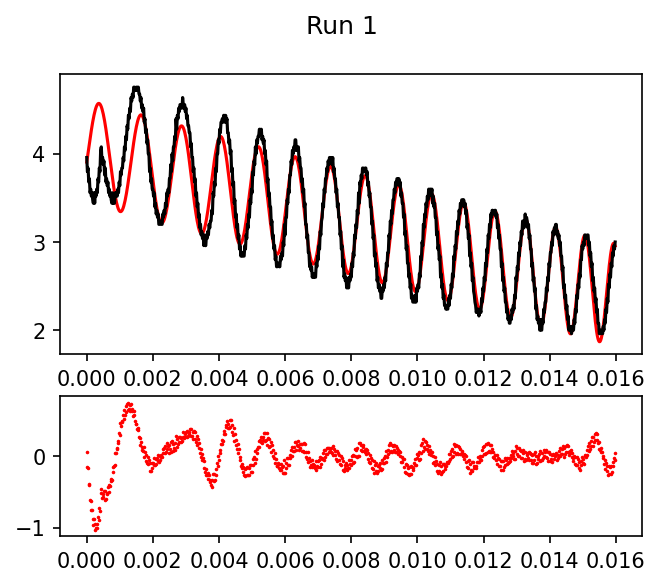

f0=1.00e+14 ± 4.13e+06
 alpha=3.34e+11 ± 1.20e+09
 A=5.83e-01 ± 1.16e-02
 a=3.45e+00 ± 2.03e-02
 b=-1.03e+02 ± 1.77e+00
 beta=5.58e+12 ± 7.33e+10


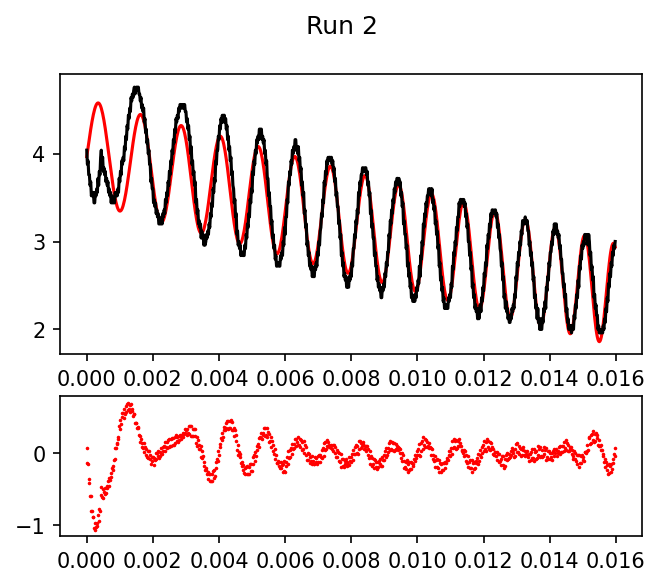

f0=1.00e+14 ± 4.38e+06
 alpha=3.25e+11 ± 1.26e+09
 A=5.78e-01 ± 1.16e-02
 a=3.48e+00 ± 2.03e-02
 b=-1.04e+02 ± 1.78e+00
 beta=6.06e+12 ± 7.62e+10


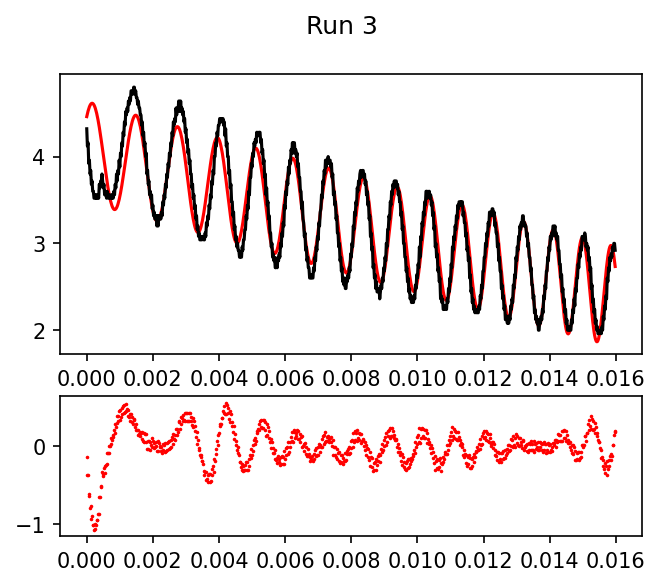

f0=1.00e+14 ± 4.22e+06
 alpha=3.23e+11 ± 1.21e+09
 A=5.85e-01 ± 1.13e-02
 a=3.48e+00 ± 1.97e-02
 b=-1.05e+02 ± 1.74e+00
 beta=6.15e+12 ± 7.33e+10


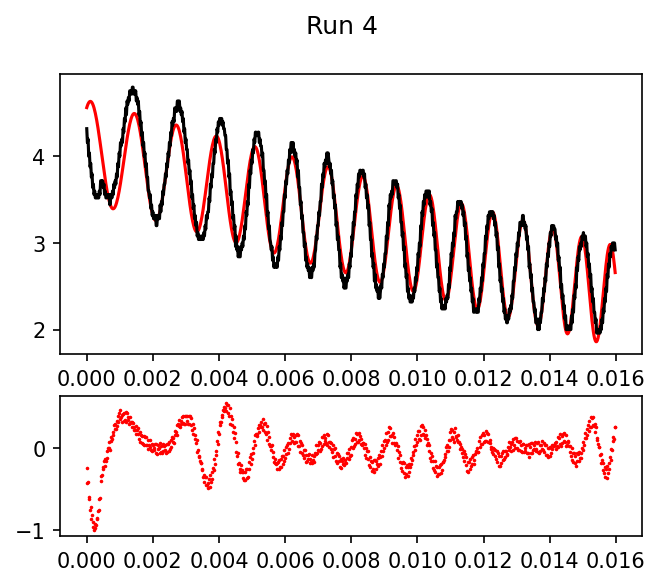

f0=1.00e+14 ± 3.91e+06
 alpha=3.22e+11 ± 1.13e+09
 A=5.95e-01 ± 1.08e-02
 a=3.48e+00 ± 1.87e-02
 b=-1.07e+02 ± 1.66e+00
 beta=6.22e+12 ± 6.79e+10


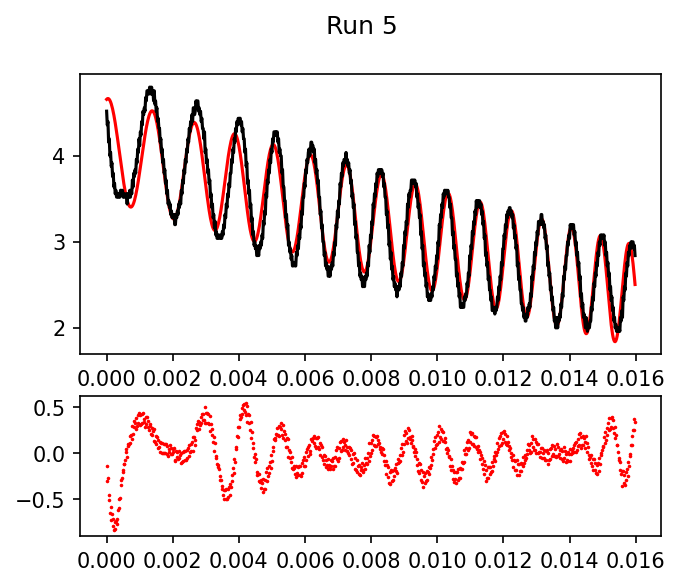

f0=1.00e+14 ± 3.51e+06
 alpha=3.23e+11 ± 1.01e+09
 A=6.10e-01 ± 1.01e-02
 a=3.51e+00 ± 1.74e-02
 b=-1.10e+02 ± 1.55e+00
 beta=6.16e+12 ± 6.11e+10


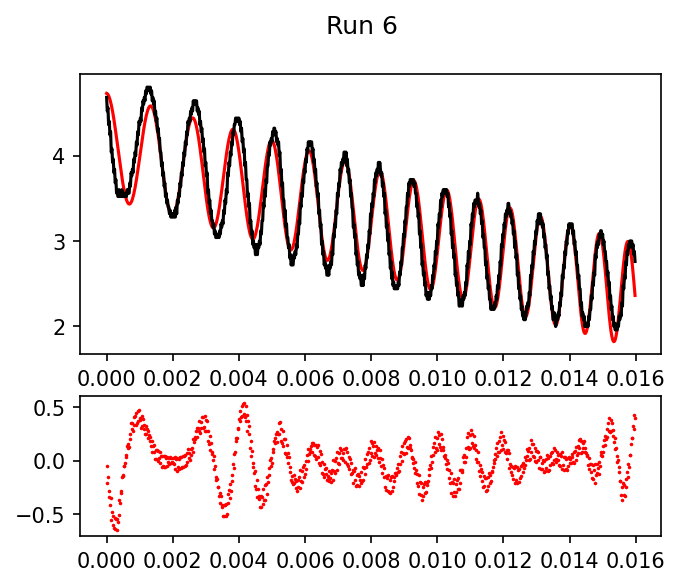

f0=1.00e+14 ± 3.39e+06
 alpha=3.23e+11 ± 9.77e+08
 A=6.12e-01 ± 9.82e-03
 a=3.52e+00 ± 1.69e-02
 b=-1.11e+02 ± 1.51e+00
 beta=6.11e+12 ± 5.90e+10


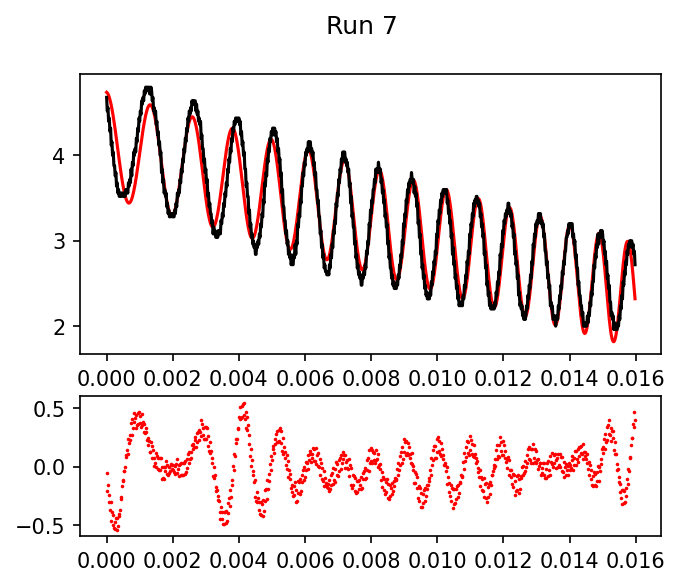

f0=1.00e+14 ± 3.43e+06
 alpha=3.23e+11 ± 9.87e+08
 A=6.10e-01 ± 9.87e-03
 a=3.52e+00 ± 1.70e-02
 b=-1.11e+02 ± 1.51e+00
 beta=6.13e+12 ± 5.96e+10


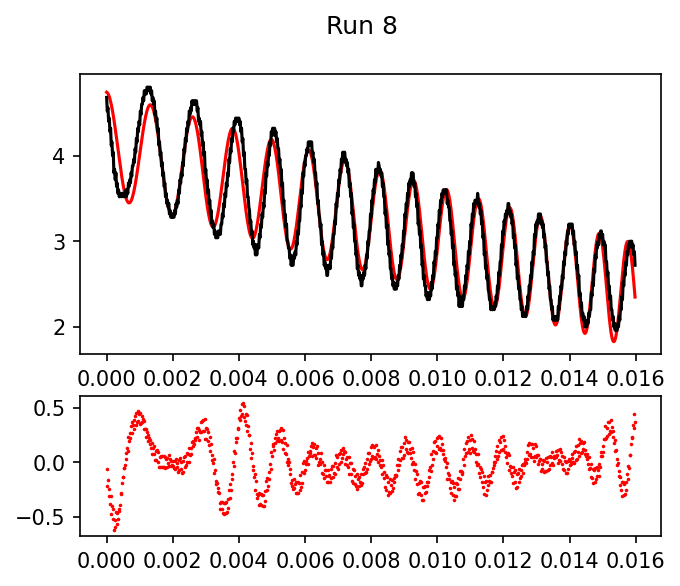

f0=1.00e+14 ± 3.11e+06
 alpha=3.27e+11 ± 8.98e+08
 A=6.18e-01 ± 9.25e-03
 a=3.54e+00 ± 1.58e-02
 b=-1.14e+02 ± 1.42e+00
 beta=5.92e+12 ± 5.43e+10


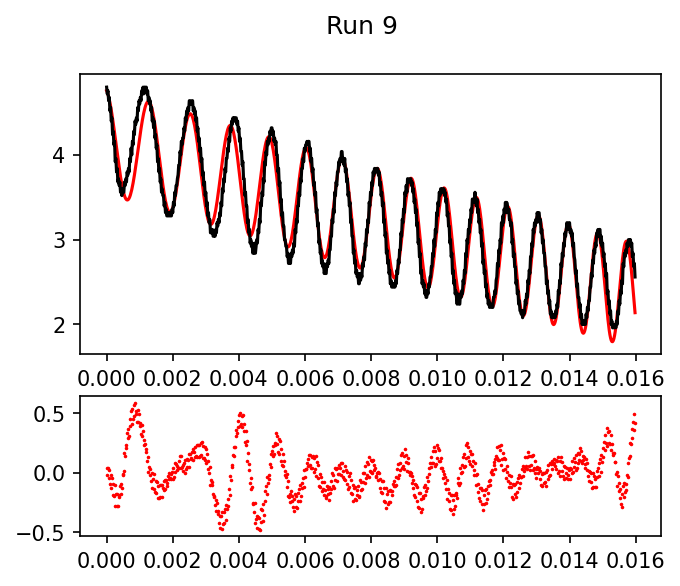

f0=1.00e+14 ± 3.05e+06
 alpha=3.30e+11 ± 8.81e+08
 A=-6.19e-01 ± 9.14e-03
 a=4.82e+00 ± 1.60e-02
 b=-1.17e+02 ± 1.40e+00
 beta=5.75e+12 ± 5.32e+10


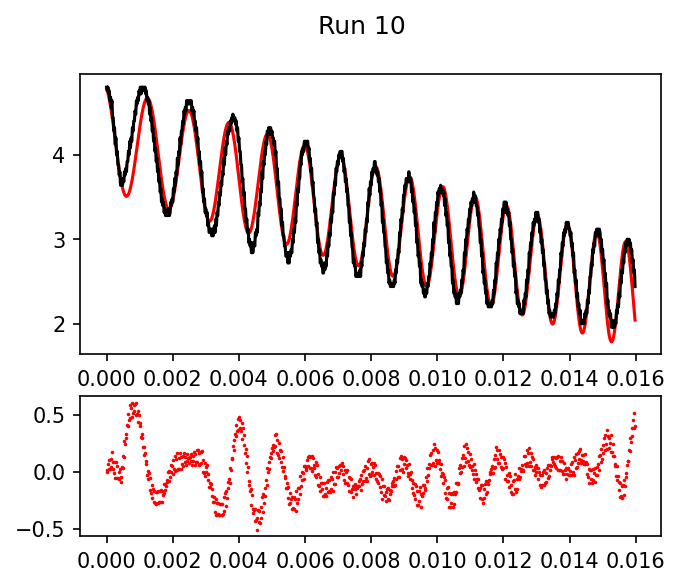

In [492]:
freq_gaps = {}

for i in range(1,11):

      # load hyperfine peaks
      hyperfine_peaks_time = hyperfine_peaks['run'+str(i)]

      # load interferometer data and find peaks in it
      inter_data = raw_probe_pump_data['run'+str(i)]['y3']

      # load the time
      time = raw_probe_pump_data['run'+str(i)]['x'] / 10  # seconds

      # trim the data
      # start = np.argwhere(inter_data == np.max(inter_data))[0][0] 
      # stop = np.argwhere(inter_data == np.min(inter_data))[0][0]
      inter_data = inter_data[0:800] 
      time = time[0:800]

      inter_peaks = find_local_maxima_inter(inter_data)

      # so we give curve fit our voltage (I) and the time, and it fits for the a,b,c parameters in f(t)
      # then we use that time_peaks = time[indices of the peaks], and evaluate f at all those times
      # everything shares the time axis, we shouldnt need to interpolate (ie the interferometer point match up in time with the probe+pump point)
      # the freq values dont actually mean anything, but the differences between them do
      # our freq gaps should be the difference between the frequency of each peaks
      # might need to add other scaling/constant terms to the fit function

      # fit the data
      alpha_guess = 4e11 if i==9 else 4.3e11
      initial_guess = [1e14, alpha_guess, 1, 4.5, -100, 1e12]  # f0, alpha, A, a, b, beta

      params, covariance = opt.curve_fit(interference_model2, time, inter_data, p0=initial_guess, maxfev=1000000000)
      errors = np.sqrt(np.diag(covariance))
      print(f'f0={params[0]:.2e} ± {errors[0]:.2e}\n',
            f'alpha={params[1]:.2e} ± {errors[1]:.2e}\n',
            f'A={params[2]:.2e} ± {errors[2]:.2e}\n',
            f'a={params[3]:.2e} ± {errors[3]:.2e}\n',
            f'b={params[4]:.2e} ± {errors[4]:.2e}\n',
            f'beta={params[5]:.2e} ± {errors[5]:.2e}')
      # residuals dont look great but this is the best I can get it at, 
      # we can try using these parameter for f(t) and see if the values we get makes sense
      # and then explain that the residuals look like shit bc theres a lot of things we dont know
      # they vary with time, they vary with other shit/ are dependent of each other
      #ie laser ramp isnt perfectly linear/quadratic, intensity isnt constant, etc...

      # use the frequency function to get the frequencies at the hyperfine peaks
      def f(t, f0, alpha, beta):
            return f0 + alpha * t + beta * t**2
      
      hyperfine_peak_freqs = f(time[hyperfine_peaks_time], params[0], params[1], params[5])

      # get the gaps between the peaks and add to the dictionary
      difference = np.diff(hyperfine_peak_freqs)
      freq_gaps['run_'+str(i)] = difference


      # # the stuff below gives us a good first look to see if our data makes sense since we get kind of the right order of magnitude
      # # but we are essentially assuming the frequency is linear with time, which is not true


      # find the time intervals between the peaks
      # time_intervals = np.diff(time[inter_peaks])

      # # convert to frequency space using delta_f = c / (2 * delta_L * time_intervals)
      # c = 3e8 # m/s
      # delta_L = 0.34 # meters
      # frequencies = c / (2 * delta_L * time_intervals)

      # # build frequency scale for this run
      # frequency_scale = np.cumsum(np.insert(frequencies, 0, 0))

      # interpolate the probe + pump data to the frequency scale
      #     time_to_frequency = interp1d(time[inter_peaks], frequency_scale, kind='linear', fill_value="extrapolate")

      # # Apply the mapping to get frequency positions of hyperfine peaks
      # hyperfine_frequencies = time_to_frequency(time[hyperfine_peaks_time])


      # # this stuff is good to use i think, only the stuff above has to change
      # # get the difference between the peaks
      # difference = np.diff(hyperfine_frequencies)

      # freq_gaps['run_'+str(i)] = difference

      fig, axes = plt.subplots(2, 1, figsize=(5,4), dpi=150, gridspec_kw={'height_ratios': [2, 1]})
      fig.suptitle(f'Run {i}')
      axes[0].plot(time, interference_model2(time, *params), color = 'r')
      axes[0].plot(time, inter_data, color = 'k')
      axes[1].scatter(time, inter_data-interference_model2(time, *params), color = 'r', s=0.5)
      plt.show()

In [493]:
freq_gaps
# we expect roughly 10e7, 10e8 Hz for the gaps between hyperfine peaks within the same broad dip
# and 10e9 Hz for the gaps between the different broad dips

{'run_1': array([6.57545738e+07, 1.10387498e+08, 7.61361714e+08, 1.56786076e+07,
        4.71420282e+07, 1.99845805e+09, 3.57293409e+07, 4.47612438e+07,
        1.73393941e+09, 4.89652109e+07, 5.89042856e+07]),
 'run_2': array([6.56229512e+07, 1.10175753e+08, 7.60193703e+08, 1.56595690e+07,
        4.70859293e+07, 1.99746302e+09, 3.57331241e+07, 4.47669261e+07,
        1.73489429e+09, 4.90111435e+07, 5.89608030e+07]),
 'run_3': array([6.44686691e+07, 1.08320274e+08, 7.50006432e+08, 1.54945408e+07,
        3.88211776e+07, 1.99698630e+09, 3.57780933e+07, 4.48316782e+07,
        1.74396124e+09, 4.94364972e+07, 5.94837535e+07]),
 'run_4': array([6.42202322e+07, 1.07919659e+08, 7.40043929e+08, 2.31786215e+07,
        3.87294735e+07, 1.99478106e+09, 3.57774917e+07, 4.48326070e+07,
        1.74530853e+09, 4.95083947e+07, 5.95724958e+07]),
 'run_5': array([6.40475141e+07, 1.00430340e+08, 7.45713470e+08, 2.31399440e+07,
        3.86660607e+07, 1.99328034e+09, 3.57778834e+07, 4.48342776e+07,
   

Taking the average of the gaps across all the runs
Note: we're ignoring every 3rd data point here, since it's the gaps between the doppler broadened peaks themselves, which we don't care about.

** other figure for the reporttt weee, we should add the theoretical values too

<ErrorbarContainer object of 3 artists>

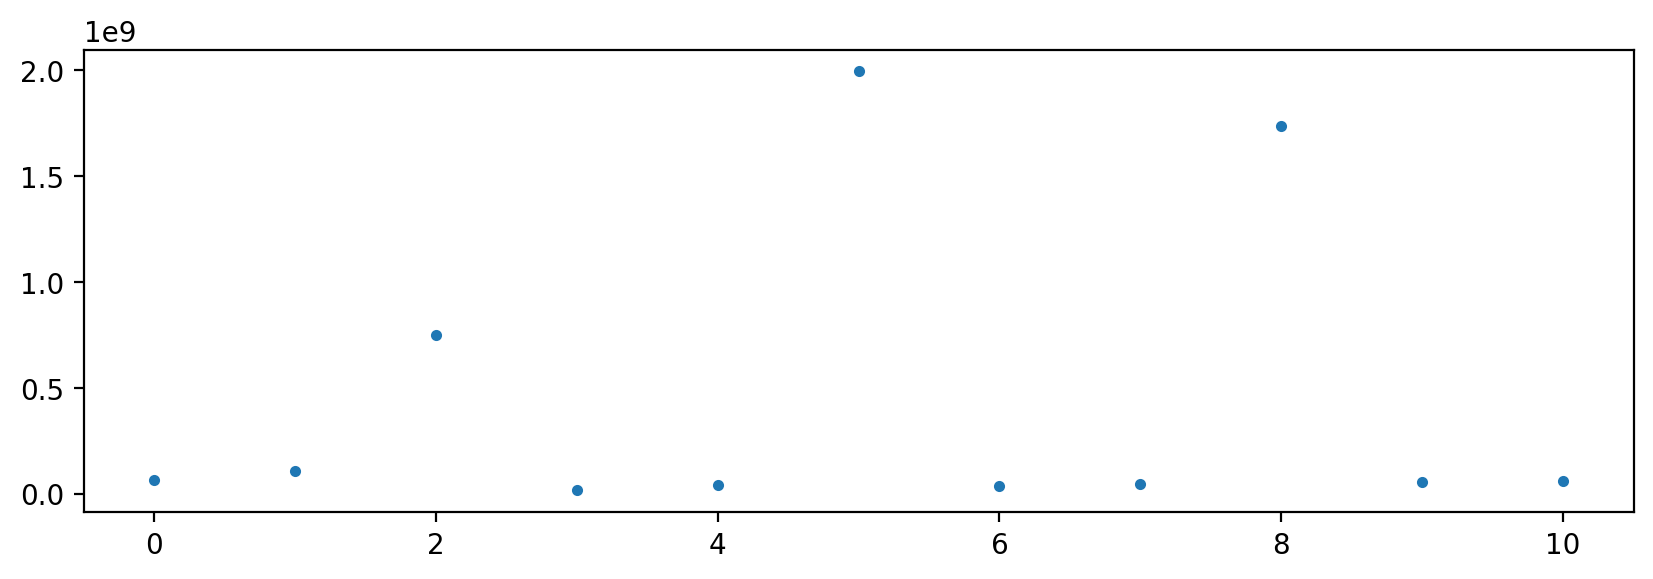

In [494]:
# taking the average across all runs
average_freq_gaps = np.mean([freq_gaps['run_'+str(i)] for i in range(1, 11)], axis = 0)

# getting the standard deviation
std_freq_gaps = np.std([freq_gaps['run_'+str(i)] for i in range(1, 11)], axis = 0)

# plotting the average frequency gaps
plt.figure(figsize = (10, 3), dpi = 200)
plt.errorbar(np.arange(len(average_freq_gaps)), average_freq_gaps, yerr = std_freq_gaps, fmt = 'o', markersize = 3)

In [495]:
# good_seps = [0, 1, 3, 4, 6, 7, 9, 10]
print('Results: ', average_freq_gaps / 1e9, 'GHz')
print('Standard Deviation: ', std_freq_gaps / 1e9, 'GHz')

Results:  [0.06391174 0.10786548 0.75045087 0.01860061 0.0427757  1.99572397
 0.03574537 0.04478902 1.73707312 0.05325834 0.05934105] GHz
Standard Deviation:  [2.12883952e-03 4.39518270e-03 6.25402147e-03 3.72762998e-03
 4.04977739e-03 1.76708856e-03 3.33708923e-05 4.47532684e-05
 7.19086059e-03 4.81672832e-03 2.67026524e-04] GHz


In [438]:
(1730402002.4921322-1730402002.444744)/2 # runs go until 0.23 so run_time/10 = seconds?

0.02369403839111328

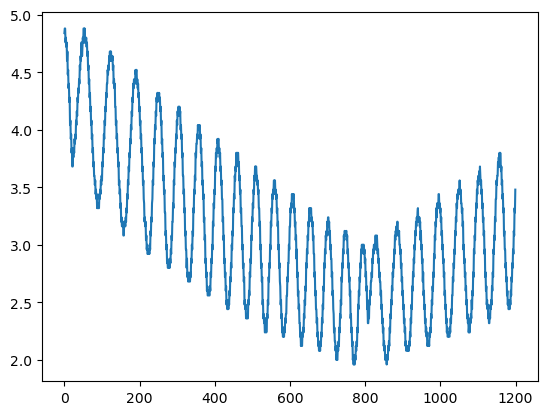

In [491]:
plt.plot(raw_probe_pump_data['run'+str(i)]['y3'])